# Measurement Noise Simulation

This notebook tries to show how to simulate the noise that comes as a result of the using of measurement devices and how this noise affects gene expression of species in a cell population. Here, gene expression of each cell is simulated deterministically through ordinary differential equations. Since this point of view all cells behave in the same way. Therefor, measurement noise is apply over the population to get different outputs from each cell. The noise is generated using a noise model that sets two noise terms. An additive term (a) that is independent and added to the output, and a mulplicative term (b) that depends on and is multiplied by the output. Aditionally, n is a variable that represents Gaussian noise.

The measurement noise simulation follows the next expression:
  *y = f + (a + b x output) x n*

In [1]:
#libraries required
import numpy as np
import simsysbio as s2b
import matplotlib.pyplot as plt

**Defines Biological System Properties**

In [2]:
####### Determine the differential equations system
#molecular species
species = ['mRNA', 'Protein']

#reagent and product matrices
reagents = np.array([[0, 1, 1, 0],[0, 0, 0, 1]])
products = np.array([[1, 0, 1, 0],[0, 0, 1, 0]])

#kinetic parameters
parameters = ['c1', 'c2', 'c3', 'c4']

#system input. It affects first reaction
inp = 'U'
idxR = 1

#gets simbolic differential equations 
equations, variables = s2b.simbODE(species, reagents, products, parameters,
                                   inputN=inp)

#muestra las ODEs obtenidas
for s in range(0, len(species)):
    print(f'd{species[s]}/dt:', equations[s])
  
print(variables)

dmRNA/dt: U*c1 - c2*mRNA
dProtein/dt: -Protein*c4 + c3*mRNA
{'species': [mRNA, Protein], 'pars': array([c1, c2, c3, c4], dtype=object), 'nameVar': array([U, mRNA, Protein], dtype=object)}


**Creates System Input**

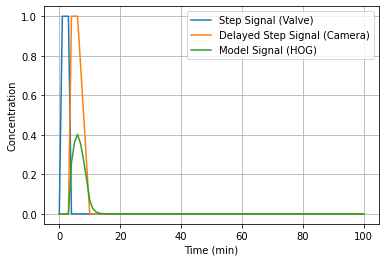

In [3]:
#computes a hog signal as system input
#duration experiment
tend = np.array([100], float)

#pulse start and end 
ton = np.array([1], float)
tdur = np.array([3], float)

#calculo de la expresion y sus respectivos perfiles
inputHOG, tog, perfiles = s2b.HOGexpr(ton, tdur, tend)

#Plotting
plt.figure()
plt.plot(tog, perfiles['t_u_Valve'], label='Step Signal (Valve)')
plt.plot(perfiles['t_u_Chamber'][0], perfiles['t_u_Chamber'][1], label='Delayed Step Signal (Camera)')
plt.plot(tog, inputHOG, label='Model Signal (HOG)')
plt.legend(loc='best')
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.grid()
plt.show()

**Solves System of Differential Equations**

In [4]:
#kinetic parameters
parsValues = [4.0, 0.010, 1.0, 0.006]

#initial concentrations
sp0 = np.zeros(len(species))

#Stores regressors
Allins = {
        "ODEs":equations,
        "inpU":inputHOG,
        "Vtime":tog,
        "species0":sp0
        }
Allins.update(variables)

Allins["idxR"] = idxR
Allins["matrizR"] = reagents
Allins["matrizP"] = products

#solucion numerica de las ODEs de expresion de las especies
exprEspecies = s2b.solveODE(parsValues, Allins)

**Plots Mean Output**

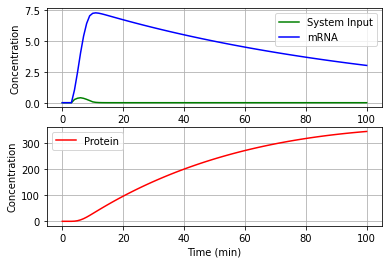

In [5]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(tog, inputHOG,'g-',label='System Input')
plt.plot(tog ,exprEspecies[0,:],'b-',label='mRNA')
plt.legend(loc='best')
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.grid()

plt.subplot(2,1,2)
plt.plot(tog , exprEspecies[1,:],'r-',label='Protein')
plt.legend(loc='best')
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.grid()

plt.show()  

**Adds Measurement Noise**

In [6]:
#number of cells
ncells = 1000

#makes ncells copies of the mean output
pcells = np.tile(exprEspecies[1,:], (ncells,1))

#creates a normal distribution of gaussian noise values
mu, sigma = 0, 1 #mean and standard deviation
ndistrib = np.random.normal(mu, sigma, (pcells.shape))

#noise parameters
a_err = 80.0
b_err = 0.05

#computes variability and noisy output
hvar = a_err + b_err*pcells     
MCy = pcells + hvar*ndistrib

**Plots Noisy Output**

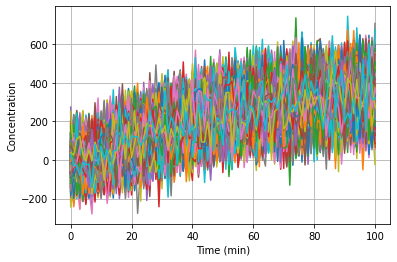

In [7]:
plt.figure()
for i in range(0,ncells):
    plt.plot(tog,MCy[i,:])
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.grid()
plt.show()

**Computes Population Output**

In [8]:
#takes quantiles contain betwenn 2.5 and 97.5 of the population distribution
ExprMin = np.quantile(MCy, 0.025, axis=0)
ExprMax = np.quantile(MCy, 0.975, axis=0)

#takes median of the population distribution
ExprMedn = np.median(MCy, axis=0)

**Plots Population Output**

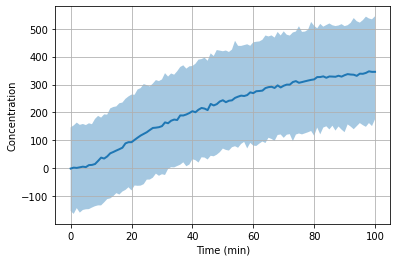

In [9]:
plt.figure()
plt.plot(tog, ExprMedn,linewidth=2)
plt.fill_between(tog, ExprMin, ExprMax, alpha = 0.4)
plt.xlabel('Time (min)')
plt.ylabel('Concentration')
plt.grid()
plt.show()